In [1]:
import pandas as pd
import numpy as np
import scipy

# some libs from kaggle
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras import utils

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

# NLP
import gensim
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
# !pip install num2words
# from num2words import num2words
# !pip install pyspellchecker
# from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# from nltk import word_tokenize
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')

# !pip install sastrawi
# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# stop_factory = StopWordRemoverFactory()

stop_id = pd.read_csv("https://raw.githubusercontent.com/irfandythalib/python-indonesia-stopwords-remover/main/tala-stopwords-indonesia.txt", header=None)[0].to_list()

## We do what?
1. using tf idf in conventional binary classification
2. using pre-trained word2vec in conventional classif -- for real idk how does word2vec works, still hahah the what is that?
3. to be doing
  1. idk, lemme explore kaggle first. hehe.
  2. word2vec for dnn
  3. try google embedding as well
  4.


## Focus in ID news

In [2]:
url = "https://drive.google.com/uc?id=1km2W3J6uMLhBtnyVxiao_GygYVzC9bC3"
df0 = pd.read_csv(url, sep=",", encoding='ISO-8859-1', on_bad_lines="skip")

url = "https://drive.google.com/uc?id=1H_Y5OVX3puMfe6ZsadWxKqhlW0O8Qh42"
df1 = pd.read_csv(url, sep=",", encoding='ISO-8859-1', on_bad_lines="skip")

df0 = pd.concat([df0, df1])
df0.reset_index(inplace=True, drop=True)
df0.shape, df0.columns, df0.Label_id.unique()

# max 271 kata
df0['Content'].apply(lambda x:len(str(x).split())).max()


271

In [3]:
%reload_ext google.colab.data_table
display(df0.head(1), df0.tail(3))

,Topic,Title,Content,Label,Label_id
0,Business,California Mengalami Kecurangan tentang Standa...,"Menyiapkan Face-Off Dengan Trump ""Badan udara ...",Fake,1


,Topic,Title,Content,Label,Label_id
1957,Celebrity,Rosie O'Donnell Menjual Mansion Pulau Star-nya...,2013-06-17T14: 07: 39-04: 00,Legit,0
1958,Celebrity,Pekerja bantuan mengklaim Angelina Jolie menga...,Seorang pekerja bantuan Kamboja mengajukan kla...,Legit,0
1959,Celebrity,Perilaku Setiva Jennifer Aniston - tidak Makan...,Jennifer Aniston adalah bintang film A-list da...,Fake,1


## Desc. & Preprocess

In [4]:
print(df0.shape)
df0.Label_id.value_counts()/df0.shape[0]*100

(1960, 5)


Label_id
1    50.0
0    50.0
Name: count, dtype: float64

In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Topic     1960 non-null   object
 1   Title     1924 non-null   object
 2   Content   1958 non-null   object
 3   Label     1960 non-null   object
 4   Label_id  1960 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 76.7+ KB


In [6]:
# drop the columns, make 1 into the preferred labels -> hoax
drop_columns = df0.columns[[0,3]]
df = df0.drop(drop_columns, axis=1)

# into content and label
df["Content"] = df.Title+". "+df.Content
df["Label"] = df.Label_id

# more dropping
df = df.drop(["Title", "Label_id"], axis=1)

# drop na
df.dropna(inplace=True)

# show percentage
print(df.shape)
df.Label.value_counts()/df.shape[0]*100

(1922, 2)


Label
1    50.156087
0    49.843913
Name: count, dtype: float64

In [7]:
# # definitely a weird way of label the data
# display(df.head(1), df.tail(1))

# Reference Here
1. [Approaching NLP in Kaggle Compet](https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle)
2. [Some NLP Series on Medium](https://medium.com/@mervebdurna/introduction-to-nlp-80f21a11c03d)
3. [Yes, a series](https://github.com/mervebdurna/10-days-NLP-blog-series)
3. We still need some valid datasets
5. [Indonesian Fast text](https://structilmy.com/blog/2019/04/15/word-embedding-bahasa-indonesia-menggunakan-fasttext-part-1/)
6. [Dataset 1](https://huggingface.co/datasets/indonlp/indonlu)
7. [Dataset 2](https://www.tensorflow.org/datasets/community_catalog/huggingface/id_nergrit_corpus)

## Split the data

In [8]:

dftr, dfva = train_test_split(df, test_size=0.3, random_state=0, stratify=df.Label)
dfva, dfte = train_test_split(dfva, test_size=0.5, random_state=0, stratify=dfva.Label)

# xtr = dftr.Content.copy()
# ytr = dftr.Label.copy()
# xva = dfva.Content.copy()
# yva = dfva.Label.copy()
# xte = dfte.Content.copy()
# yte = dfte.Label.copy()

# xtr.shape, yva.shape, xte.shape


In [9]:
# Relevant text normalization processes -> lowercase, tokenize, rm punc.
def convert_to_lowercase(text): return text.lower()
def remove_punctuation(text):
  punct_str = string.punctuation
  # punct_str = punct_str.replace("'", "")
  return text.translate(str.maketrans("", "", punct_str))

def text_preprocess(text):
  text = convert_to_lowercase(text)
  text = remove_punctuation(text)
  return text

regexp = RegexpTokenizer("[\w']+")


dftr1 = dftr.copy()
dfva1 = dfva.copy()
dfte1 = dfte.copy()

for df in [dftr1, dfva1, dfte1]:
  df["Content"] = df["Content"].apply(text_preprocess)
  df["tokens"] = df["Content"].apply(regexp.tokenize)

# ML semua.
uji_token = regexp.tokenize(text_preprocess("ini uji coba bisa gak ya ini isinya hoaks ayo makan barengn klasifikasi"))

## Building Basic Model (tf - idf)
1. I guess they automatically remove the punctuation and do the lowercase.

In [10]:
tfv = TfidfVectorizer(min_df=3,  max_features=None,
                      strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                      stop_words = stop_id)

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(dftr1.Content))

xtr_tf = tfv.transform(dftr1.Content)
xva_tf = tfv.transform(dfva1.Content)
xte_tf = tfv.transform(dfte1.Content)

uji_tf = tfv.transform(["ini uji coba bisa gak ya ini isinya hoaks ayo makan barengn klasifikasi"])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [11]:
xtr_tf.shape, xva_tf.shape, xte_tf.shape

((1345, 9573), (288, 9573), (289, 9573))

In [12]:
# Fitting a simple Logistic Regression on TFIDF
lr1 = LogisticRegression(C=1.0)
lr1.fit(xtr_tf, dftr1.Label)

nb1 = GaussianNB()
nb1.fit(xtr_tf.toarray(), dftr1.Label)

# uji coba predict.
lr1.predict_proba(uji_tf.toarray())

array([[0.63180747, 0.36819253]])

In [13]:
def print_res(model=lr1, y=dfva1.Label, x=xva_tf):
  prob = model.predict_proba(x)[:,1]
  pred = model.predict(x)

  print("roc score {:0.3f}".format(metrics.roc_auc_score(y, prob)))
  print(metrics.classification_report(y, pred))
  print(metrics.confusion_matrix(y, pred))
  print("\n")

print_res()
print_res(nb1, x=xva_tf.toarray())

roc score 0.784
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       144
           1       0.74      0.76      0.75       144

    accuracy                           0.75       288
   macro avg       0.75      0.75      0.75       288
weighted avg       0.75      0.75      0.75       288

[[106  38]
 [ 35 109]]


roc score 0.750
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       144
           1       0.78      0.69      0.74       144

    accuracy                           0.75       288
   macro avg       0.75      0.75      0.75       288
weighted avg       0.75      0.75      0.75       288

[[116  28]
 [ 44 100]]




In [14]:
# Classifiers
names = [
    "Logistic Regression",
    # "KNN Classifier",
    "Decision Tree",
    # "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    # "Ridge Classifier",
    "XGBoost",
    "AdaBoost"
]

models = [
    LogisticRegression(max_iter = 1000),
    # KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    # svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'log_loss'),
    # RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        print(names[i])
        y_train_pred, y_val_pred = model.predict_proba(X_train)[:, 1], model.predict_proba(X_val)[:, 1]
        score_train.append(metrics.roc_auc_score(y_train, y_train_pred))
        score_val.append(metrics.roc_auc_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df


# Summary of baseline models
score(xtr_tf, dftr1.Label, xva_tf, dfva1.Label, names = names, models = models)


Logistic Regression
Decision Tree
Random Forest
SGD Classifier
XGBoost
AdaBoost


,Classifier,Training accuracy,Validation accuracy
2,Random Forest,1.000000,0.949219
4,XGBoost,0.999417,0.912133
1,Decision Tree,1.000000,0.895833
3,SGD Classifier,0.999695,0.866657
0,Logistic Regression,0.989504,0.784481
5,AdaBoost,0.897123,0.754485


### Word Vectors
Using pre-trained word vectors
1. glove vectors &rarr; can't find any pre-trained one
2. word2vec &rarr; found, idk how to process, lemme find some ref first
3. fasttext &rarr; still trying, so heavy dude.

[From this Link](https://www.kaggle.com/code/sugataghosh/e-commerce-text-classification-tf-idf-word2vec)
> Standard text normalization processes like stemming, lemmatization or removal of stop words are not recommended when we have pre-trained embeddings. The reason behind this is that valuable information, which could be used by the neural network, is lost by those preprocessing steps. Here we shall consider a few selected text normalization processes only, before we feed the tokenized words to the pre-trained model to get the embeddings.

In [15]:
# i'll skip the 2nd one first
wvec1 = "https://drive.google.com/uc?id=1lmZuikAJ5t69lZMvx4iKfnsMDS9UI3HB"
wvec2 = "https://drive.google.com/uc?id=1PfuUEHmN6shLxcgqw0ApM6-LR-hZ4fSy"
wvec3 = "https://drive.google.com/uc?id=1X5ZPsaoXFxJFrcJ7pVkV9VC81lmDIzdI"

!gdown "https://drive.google.com/uc?id=1X5ZPsaoXFxJFrcJ7pVkV9VC81lmDIzdI" ## whoah a 1/4 to a gb

Downloading...
From (original): https://drive.google.com/uc?id=1X5ZPsaoXFxJFrcJ7pVkV9VC81lmDIzdI
From (redirected): https://drive.google.com/uc?id=1X5ZPsaoXFxJFrcJ7pVkV9VC81lmDIzdI&confirm=t&uuid=52e45b8f-b1a5-43d9-ab84-45d2d0f4a717
To: /content/idwiki_word2vec_300.zip
100% 746M/746M [00:26<00:00, 28.3MB/s]


In [16]:
# # fast text but super slow
# !pip install fasttext
# import fasttext.util

# # download dude -> 7 minutes and not yet done. oh it's 1gb haha.
# fasttext.util.download_model('id', if_exists='ignore')
# ft1 = fasttext.load_model('cc.id.300.vec.gz')

### Fitting WVs into a simple classifier
1. eh, idk how to work with word2vec ehhe.

In [17]:
!unzip "/content/idwiki_word2vec_300.zip" -d "/content/word2vec"

Archive:  /content/idwiki_word2vec_300.zip
  inflating: /content/word2vec/idwiki_word2vec_300.model.trainables.syn1neg.npy  
  inflating: /content/word2vec/idwiki_word2vec_300.model.wv.vectors.npy  
  inflating: /content/word2vec/idwiki_word2vec_300.model  


In [18]:
pwv = '/content/word2vec/idwiki_word2vec_300.model'
id_w2v = gensim.models.word2vec.Word2Vec.load(pwv)

In [19]:
dir(id_w2v.wv)
# id_w2v.wv.most_similar_cosmul()
id_w2v.wv

In [20]:
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)



In [21]:
xtr_em = get_word2vec_embeddings(id_w2v.wv, dftr1['tokens'])
xva_em = get_word2vec_embeddings(id_w2v.wv, dfva1['tokens'])
xte_em = get_word2vec_embeddings(id_w2v.wv, dfte1['tokens'])

uji_em = get_word2vec_embeddings(id_w2v.wv, pd.DataFrame(uji_token))


In [22]:
# Converting to Compressed Sparse Row matrix
xtr_w2v = scipy.sparse.csr_matrix(xtr_em)
xva_w2v = scipy.sparse.csr_matrix(xva_em)
xte_w2v = scipy.sparse.csr_matrix(xte_em)

# ini tinggal di predict
uji_em = scipy.sparse.csr_matrix(xte_em)

In [23]:
# score(xtr_tfv, ytr, xtr_tfv, yva, names = names, models = models)
score(xtr_w2v, dftr1.Label, xva_w2v, dfva1.Label,
      names = names, models = models)


Logistic Regression
Decision Tree
Random Forest
SGD Classifier
XGBoost
AdaBoost


,Classifier,Training accuracy,Validation accuracy
2,Random Forest,1.000000,0.976514
4,XGBoost,1.000000,0.964217
1,Decision Tree,1.000000,0.854167
5,AdaBoost,0.936460,0.852382
0,Logistic Regression,0.888500,0.772521
3,SGD Classifier,0.900389,0.768808


### Finally fit into DNN (NO IDK)
1. architecture to try: sequential of dense, batchnormalization, dense, dropout, batchnormalization, and dense
2. using keras tokenizer to use lstm &rarr; well, must be padded first, you know
  1. getting the embedded word via wordvec.
  2. train
  3. architecture &rarr; embedding of the word index, spatial do, lstm, dense, do, dense, do, and dense
  3. early stopping is not recommended
4. try bi lstm
4. try gru
5. try cnn
6. not yet &rarr; try stemming and lemmatization


In [34]:
# Summary of baseline models
# score(xtr_tf, dftr1.Label, xva_tf, dfva1.Label, names = names, models = models)
import tensorflow as tf
import matplotlib.pyplot as plt

In [43]:
# plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# dimension
NUM_EPOCHS = 50
BATCH_SIZE = 32


In [44]:
# Parameters
embedding_dim = 16
dense_dim = 8

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    # tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # tf.keras.layers.Dropout(0.7),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



Epoch 1/50
43/43 [==============================] - 1s 11ms/step - loss: 0.6919 - accuracy: 0.5428 - val_loss: 0.6897 - val_accuracy: 0.6354
Epoch 2/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6798 - accuracy: 0.6372 - val_loss: 0.6850 - val_accuracy: 0.6597
Epoch 3/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6569 - accuracy: 0.7019 - val_loss: 0.6779 - val_accuracy: 0.6424
Epoch 4/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6287 - accuracy: 0.7613 - val_loss: 0.6661 - val_accuracy: 0.7014
Epoch 5/50
43/43 [==============================] - 0s 6ms/step - loss: 0.5917 - accuracy: 0.8059 - val_loss: 0.6529 - val_accuracy: 0.7257
Epoch 6/50
43/43 [==============================] - 0s 6ms/step - loss: 0.5558 - accuracy: 0.8349 - val_loss: 0.6388 - val_accuracy: 0.7257
Epoch 7/50
43/43 [==============================] - 0s 6ms/step - loss: 0.5249 - accuracy: 0.8379 - val_loss: 0.6264 - val_accuracy: 0.7257
Epoch 8/50
43/43 [=

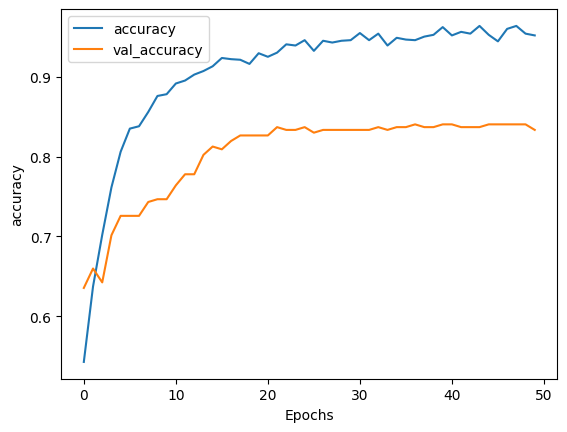

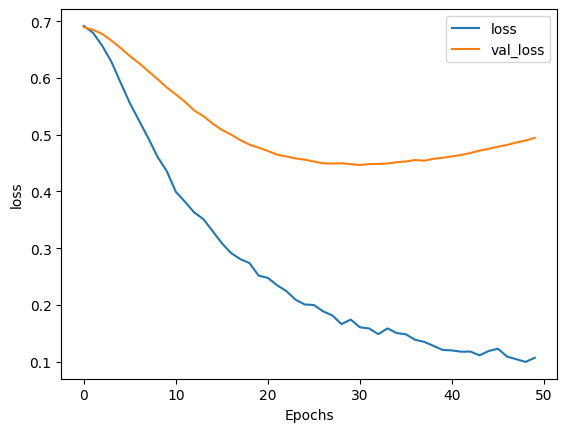

In [45]:
# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


# Train the model
history_flatten = model_flatten.fit(xtr_tf.toarray(), dftr1.Label, batch_size=BATCH_SIZE,
                                    epochs=NUM_EPOCHS, validation_data=(xva_tf.toarray(), dfva1.Label))


# # Print the model summary
# model_flatten.summary()

# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')


### TF IDF extras

In [ ]:
# tfv = TfidfVectorizer(min_df=3,  max_features=None,
#                       strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
#                       ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
#                       stop_words = stop_id)

# # Fitting TF-IDF to both training and test sets (semi-supervised learning)
# tfv.fit(list(dftr1.Content))

# xtr_tf = tfv.transform(dftr1.Content)
# xva_tf = tfv.transform(dfva1.Content)
# xte_tf = tfv.transform(dfte1.Content)

# uji_tf = tfv.transform(["ini uji coba bisa gak ya ini isinya hoaks ayo makan barengn klasifikasi"])

In [ ]:
all0 = " ".join(dftr.loc[dftr.Label==0, "Content"])
all1 = " ".join(dftr.loc[dftr.Label==1, "Content"])

vector01 = TfidfVectorizer(min_df=2,  max_features=None,
                           strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                           ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
                           stop_words=None)

vector01.fit(list([all0, all1]))

In [ ]:
ehm = vector01.transform([dfte.iloc[0,0]])
print(ehm.shape)
vector01.inverse_transform(ehm), vector01.inverse_transform(ehm.toarray())

In [ ]:
pd.DataFrame(dfte.iloc[3,0].lower().split()).value_counts()[:20]

In [ ]:
# idk what the what is this?
ehm = vector01.transform([dfte.iloc[3,0]])
flat = ehm.toarray().flatten()


top = np.argpartition(flat,-10)[-10:]
names = vector01.get_feature_names_out()


top_terms = [(names[i], flat[i]) for i in top]
top_terms = sorted(top_terms, key=lambda x: x[1], reverse=True)

top_terms